# Document Classification Pipeline

Before you run this script make sure you run 

`pip install -r requirements.txt`

This script:  
1) Loads Reddit comments from mental health subreddits  
2) Preprocesses the comments   
3) Fits a logistic regressoin classifier that distinguishes between   
4) Generates model evaluation   
5) Generates lists of words that are useful for classifiing between subreddits   
6) Shows the comments most likely to be from each subreddit as predicted by the model

In [1]:
import nltk
import ujson
import numpy as np
import re 
import time
import matplotlib.pyplot as plt
import pprint
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score
from collections import Counter
from nltk.corpus import stopwords
from nltk import SnowballStemmer


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Garren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Options 

# Count Vectorizer 
RE_PREPROCESS = r'\W+|\d+' # text preprocessing on input 
ANALYZER = "word"          # CountVectorizer also supports character tokenization 
TOKENIZER = None           # can pass custom tokenization function 
STRIP_ACCENTS = 'unicode'  # gets rid of accents 
NGRAM_RANGE = (0,2)        # unigrams and bigrams 
MIN_DF = 0.01              # minimum document frequency 
MAX_DF = 0.8               # maximum document frequency 
MIN_CHARACTERS = 30        # shortest acceptable comment 

# TfIdf
NORM = None
SMOOTH_IDF = True 
SUBLINEAR_IDF = True 
USE_IDF = True 

In [3]:
def load_reddit_mh( filename = 'RC_2015-05.json', subreddits = ['SuicideWatch', 'depression'], MIN_CHARACTERS = 100):
    """
    Function to import Reddit comments from mental helth forums from May 2015 
    
    params: 
        str filename: name of file to open 
        list(str): name of subreddits we would like to load
        int MIN_CHARACTERS: thresholds comments we load by comment length (in characters) 
    """
    if len(subreddits) != 2:
        raise ValueError('read_reddit_mh only takes two subreddits')
    corpus = []
    subreddit_id = []
    with open(filename, 'r') as f:
        for line in f:
            json_dict = ujson.loads(line)
            subreddit = json_dict['subreddit']
            if subreddit in subreddits:
                comment = json_dict['body']
                if len(comment) > MIN_CHARACTERS:
                    corpus.append(comment)
                    subreddit_id.append(subreddits.index(subreddit))
    return [corpus, subreddit_id]


## Load Data

In [7]:
# Load data from subreddits 
subreddits = ['SuicideWatch', 'depression']
[corpus, subreddit_id] = load_reddit_mh(subreddits = subreddits, MIN_CHARACTERS = MIN_CHARACTERS)
subreddit_id = np.asarray(subreddit_id)

# Get rid of punctuation and set to lowercase  
processed_corpus = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus]

# Comment counts from each subreddit 
print(Counter(subreddit_id))

Counter({1: 24683, 0: 12610})


## Preprocessing: Count Vectorizer 

CountVectorizer [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

TfidfTransformer [Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [8]:
def tokenize_and_stem(text, stemmer= SnowballStemmer('english')):
    """
    Function to tokenize petitions using Snowballstemmer
    params:
        string text: text to be tokenized and stemmed
        stemmer: function for stemming text
    """
    tokens = text.split()
    return [ stemmer.stem(token) for token in tokens]

In [9]:
vectorizer = CountVectorizer(analyzer=ANALYZER,
            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
            ngram_range=(0,2),
            stop_words = stopwords.words('english'),
            strip_accents=STRIP_ACCENTS,
            min_df = MIN_DF,
            max_df = MAX_DF)

transformer = TfidfTransformer(
                norm = NORM,
                smooth_idf = SMOOTH_IDF,
                sublinear_tf = True)

In [10]:
#vectorizer

In [11]:
# Put corpus into a bag of words, get features from the count vectorizer 
start_time = time.time()
bag_of_words = vectorizer.fit_transform( processed_corpus )
if USE_IDF: 
    tfidf = transformer.fit_transform(bag_of_words) 
features = vectorizer.get_feature_names()
end_time = time.time()
print("Processing took {}s".format(end_time-start_time)) # takes 14s without stemming 

Processing took 12.4480400085s


In [12]:
#bag_of_words
#features

## Fit Classifier

In [13]:
# split data into train and test
train_set_size = int(.80*len(subreddit_id))

train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size,len(subreddit_id))
 
print('Train Labels: ', Counter(subreddit_id[train_idx]))
print('Test Labels: ', Counter(subreddit_id[test_idx]))

('Train Labels: ', Counter({1: 19382, 0: 10452}))
('Test Labels: ', Counter({1: 5301, 0: 2158}))


In [14]:
#X = bag_of_words 
X = tfidf

mdl = LogisticRegression( penalty = 'l1')
mdl.fit(X[train_idx,], subreddit_id[train_idx] )

y_score = mdl.predict_proba( X[test_idx])

## Evaluate Model

In [15]:
[precision, recall, threshold] = precision_recall_curve( subreddit_id[test_idx], y_score[:,1])
auc = roc_auc_score( subreddit_id[test_idx], y_score[:,1])
threshold = np.insert(threshold,0,0)

print(auc)

0.649568541022


In [16]:
x = np.arange(len(recall))/float(len(recall))
recall = recall[::-1]
precision= precision[::-1]

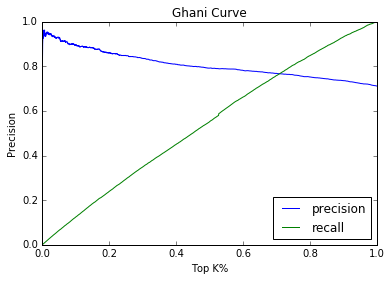

In [17]:
# Plot Ghani Curve 
plt.clf()
plt.plot(x, precision, label='Ghani Curve')
plt.plot(x, recall)
plt.xlabel('Top K%')
plt.ylabel('Precision')
plt.legend(['precision', 'recall'],loc="lower right")
plt.title('Ghani Curve')
plt.show()

## Generate list of words most useful for classification

In [18]:
# See which words are correlated with being classified as subreddit1 or subreddit2 
coef = mdl.coef_[0]
num_features = 5
coef_index = coef.argsort()
subreddit1_features = [ features[i] for i in coef_index[-num_features:]]
subreddit2_features = [ features[i] for i in coef_index[:num_features]]
print(subreddit1_features)
print(coef[coef_index[-num_features:]])
print(subreddit2_features)
print(coef[coef_index[:num_features]])


[u'helps', u'psychiatrist', u'depressed', u'effects', u'depression']
[ 0.12033589  0.13568213  0.13642369  0.1870128   0.32267604]
[u'suicide', u'please', u'talked', u'suicidal', u'hospital']
[-0.1676791  -0.16323765 -0.11455768 -0.10142495 -0.09820164]


## Comments most likely to be from each subreddit 

In [19]:
num_comments = 10
subreddit1_comment_idx = y_score[:,1].argsort()[-num_comments:]
subreddit2_comment_idx = y_score[:,1].argsort()[:num_comments]

for i in subreddit1_comment_idx:
    print(u"***{}, {}***:\n {}\n".format(subreddits[subreddit_id[test_idx[i]]], 
                                np.around(y_score[i,1], decimals =3), corpus[test_idx[i]]))

***depression, 0.997***:
 Yes, that's true. You've got to know that psychiatrists still focus on the medical aspect of mental illnesses and not on psychotherapy. Usually with psychiatrists, it's better to just give enough context to describe your depression, like what significant feelings upset you or other big concerns. This is just so you can elaborate everything with your therapist, because that's what therapists focus on. And if you do spill out stuff with your psychiatrist most of the time, then you'll lose the need to share the same things with your therapist since it's already out of your system. Just my two cents.

Also, does your psychiatrist and therapist know each other? While your secrets or the events you've shared to your therapist (or psych) are completely confidential - they're not allowed to exchange those matters, ethically speaking) - usually the psychiatrist can call your therapist to update on your medications on any physical concerns (e.g. self-harm, headaches, me

In [20]:
for i in subreddit2_comment_idx:
    print(u"***{}, {}***:\n {}\n".format(subreddits[subreddit_id[test_idx[i]]], 
                                np.around(y_score[i,1], decimals =3), corpus[test_idx[i]]))
    

***SuicideWatch, 0.01***:
 It sounds like you're exhausted on many levels and are losing hope or have lost hope. I'm so sorry. 

For what it's worth, it's striking that you give equal weight in your post to your personal struggles and your existential despair at the state of the world. That's pretty remarkable - it speaks to your empathy. You are not worthless. I think that you want to help people. You say that you don't even know why you try - but it sounds like you do know. You care about the world so much that it hurts. Helping people gives life meaning, right? And sometimes jerks may deny that or try to take that from you, but we all have to fight them. 

I know that I can't imagine the added pain of being trans in a hostile world, though some of this, I get. I'm queer too and not in a good situation right now and it sounds like you've got something eating disordered type stuff going on - that certainly makes the world a harder place to live in. There is help out there though. Pers

# Topic Modeling 

In [31]:
N_TOPICS = 50
N_TOP_WORDS = 10 

def load_all_reddit_mh( directory = '.', filenames = ['RC_2015-01', 'RC_2015-02', 'RC_2015-03', 'RC_2015-04', 'RC_2015-05'], MIN_CHARACTERS = 50):
    """
    Function to import Reddit comments from mental health forums from May 2015 
    
    params: 
        str filename: name of file to open 
        int MIN_CHARACTERS: thresholds comments we load by comment length (in characters) 
    """
    corpus = []
    subreddit_id = []
    subreddits = []
    for filename in filenames: 
        with open(directory + '/' + filename, 'r') as f:
            for line in f:
                json_dict = ujson.loads(line)
                subreddit = json_dict['subreddit']
                comment = json_dict['body']
                if len(comment) > MIN_CHARACTERS:
                    corpus.append(comment)
                    if subreddit in subreddits:
                        pass
                    else: 
                        subreddits.append(subreddit)
                    subreddit_id.append(subreddits.index(subreddit))
    return [corpus, subreddit_id, subreddits]



In [32]:
start = time.time()
[corpus_all, subreddit_id_all, subreddits_all] = load_all_reddit_mh(filenames=['RC_2015-05.json'], MIN_CHARACTERS = MIN_CHARACTERS)

# Get rid of punctuation and set to lowercase  
processed_corpus_all = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus_all]

bag_of_words_all = vectorizer.fit_transform( processed_corpus_all )
end = time.time() 
print("Processing took {}s".format(end - start)) # takes ~62s for 1 file, 401s for 5 files 

Processing took 69.8867549896s


In [26]:
print(Counter(subreddit_id_all), len(subreddit_id_all))

(Counter({0: 133391, 1: 114579, 3: 102777, 5: 83124, 8: 57846, 2: 56590, 10: 44764, 11: 38184, 13: 35662, 18: 23305, 4: 16030, 12: 15127, 17: 13284, 7: 12908, 9: 7848, 27: 6511, 23: 5688, 14: 4924, 22: 4488, 15: 3586, 24: 2752, 26: 2071, 6: 2052, 16: 1901, 30: 1834, 19: 1564, 20: 1513, 31: 1399, 33: 1192, 40: 1098, 21: 948, 28: 582, 36: 309, 35: 248, 25: 217, 34: 186, 29: 142, 41: 126, 45: 85, 37: 56, 48: 49, 39: 47, 52: 35, 42: 30, 32: 28, 50: 28, 38: 19, 46: 16, 47: 16, 43: 14, 44: 14, 53: 14, 49: 11, 54: 9, 51: 7}), 801228)


In [33]:
start = time.time()
lda = LatentDirichletAllocation( n_topics = N_TOPICS )
lda.fit_transform( bag_of_words_all )
end = time.time() 
print("Processing took {}s".format(end- start)) # takes ~72s for 1 file, ~445s for 5 files 

Processing took 260.475250959s


In [25]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx, ", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("\nTopics in LDA model:")

print_top_words(lda, features, N_TOP_WORDS)


Topics in LDA model:
('Topic #0:', u'stuff, feels, like, definitely, music, really, must, stupid, together, feels like')
('Topic #1:', u'job, actually, time, really, get, work, meds, like, think, even')
('Topic #2:', u'people, like, kind, see, around, talking, know, meet, said, person')
('Topic #3:', u'someone, care, many, pain, nice, help, know, talk, writing, people')
('Topic #4:', u'thoughts, thinking, free, suicidal, kill, treatment, rather, helpful, horrible, physical')
('Topic #5:', u'people, life, place, things, think, make, want, like, future, even')
('Topic #6:', u'want, talk, make, need, pm, glad, feel, least, help, want talk')
('Topic #7:', u'feeling, anything, nothing, hate, helps, wrong, chance, taking, trust, agree')
('Topic #8:', u'feel, like, feel like, try, something, live, everything, maybe, way, never')
('Topic #9:', u'could, wish, worth, wish could, sucks, get, anything, someone, seeing, enjoy')
('Topic #10:', u'man, im, call, anymore, lost, left, cry, cant, says, 